# Compare Models Performance

In [1]:
# Setup logging level

import logging

logging.basicConfig(level=logging.ERROR)

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score

sns.set_theme(style="whitegrid", palette="colorblind")
palettes = ["Purples", "Blues", "Greens", "Oranges", "RdPu", "Greys"]

In [3]:
report_path = Path("report")
report_path.mkdir(exist_ok=True)

figure_path = report_path / "figures"
figure_path.mkdir(exist_ok=True)

result_path_base = Path("../results/")

## Load Experimental Data

In [4]:
# Define paths to the results files
# "Claude 3.5 Sonnet P2": Path("../results/results_claude-3-5-sonnet-20241022_on_haiku-haiku_USER_PROMPT2.csv"),
# "DeepSeek V3 P2": Path("../results/results_deepseek-chat_on_haiku-haiku_USER_PROMPT2.csv"),

from typing import Dict

nice_model_names = {
    "claude-3-5-haiku-20241022": "Claude 3.5 Haiku",
    "claude-3-5-sonnet-20241022": "Claude 3.5 Sonnet",
    "deepseek-chat": "DeepSeek V3",
    "deepseek-reasoner": "DeepSeek R1",
    "gemini-1.5-flash": "Gemini 1.5 Flash",
    "gpt-4o-2024-11-20": "GPT-4o",
}


def load_csvs(result_path_base: Path) -> Dict[str, Dict[str, pd.DataFrame]]:
    dataframes = {}
    for result_path in result_path_base.glob("*.csv"):
        result_df = pd.read_csv(result_path)
        result_name = result_path.name
        # remove the file extension
        result_name = result_name[:-4]
        split_ = result_name.split("_")
        model_name = split_[1]
        model_name = nice_model_names.get(model_name, model_name)
        debate_name = split_[3]
        variation = ""
        if len(split_) > 5:
            variation = split_[4]
        if debate_name not in dataframes:
            dataframes[debate_name] = {}
        dataframes[debate_name][model_name + variation] = result_df

    return dataframes


results = load_csvs(result_path_base)
for debate_name, models in results.items():
    print(f"===== {debate_name} =====")
    for model_name, results_df in models.items():
        print(model_name)
        print(len(results_df))

===== haiku-haiku =====
Claude 3.5 Haiku
360
Claude 3.5 Sonnet
360
DeepSeek V3
360
DeepSeek R1
1
Gemini 1.5 Flash
360
GPT-4o
359
===== sonnet-sonnet =====
Claude 3.5 Haiku
360
Claude 3.5 Sonnet
360
DeepSeek V3
122
Gemini 1.5 Flash
360
GPT-4o
360


In [5]:
all_models = sorted(
    set([model for models in results.values() for model in models.keys()])
)
model_palette = dict(zip(all_models, palettes))
print(model_palette)

{'Claude 3.5 Haiku': 'Purples', 'Claude 3.5 Sonnet': 'Blues', 'DeepSeek R1': 'Greens', 'DeepSeek V3': 'Oranges', 'GPT-4o': 'RdPu', 'Gemini 1.5 Flash': 'Greys'}


In [6]:
# Optional: Remove rows where none of the debater argued for the correct answer
print("Removing rows where none of the debater argued for the correct answer")
for debate_name, model_dfs in results.items():
    for model, df in model_dfs.items():
        print(model)
        print(f"Length before: {len(df)}")
        # Check the accuracy for when none of the debaters argued for the correct answer
        all_wrong_df = df[df["correct_debater_pos"] == -1]
        acc = accuracy_score(all_wrong_df["label"], all_wrong_df["judge"])
        print(
            f"Accuracy when none of the debaters argued for the correct answer: {acc}"
        )
        model_dfs[model] = df[df["correct_debater_pos"] != -1]
        print(f"Length after: {len(model_dfs[model])}")
        print()

Removing rows where none of the debater argued for the correct answer
Claude 3.5 Haiku
Length before: 360
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 240

Claude 3.5 Sonnet
Length before: 360
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 240

DeepSeek V3
Length before: 360
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 240

DeepSeek R1
Length before: 1
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 0

Gemini 1.5 Flash
Length before: 360
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 240

GPT-4o
Length before: 359
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 240

Claude 3.5 Haiku
Length before: 360
Accuracy when none of the debaters argued for the correct answer: 0.0
Length after: 240

Claude 3.5 Sonnet
Length before: 360
Accuracy when none of the debaters argued

## Calculate Performance Metrics

In [7]:
# Load and process data
metrics = []
for debate_name, dataframes in results.items():
    for model, df in dataframes.items():
        # Calculate metrics for each conflict level
        for level in ["LowConflict", "HighConflict"]:
            # Calculate metrics for each label
            for label in ["proved", "disproved", "unknown"]:
                # Calculate metrics for each correct debater position
                # for correct_debater_pos in [-1, 1, 2]:
                #     pos_df = df[df["correct_debater_pos"] == correct_debater_pos]
                # label_df = pos_df[pos_df["label"] == label]
                label_df = df[df["label"] == label]
                level_df = label_df[label_df["level"] == level]

                if len(level_df) > 0:
                    baseline_accuracy = accuracy_score(
                        level_df["label"], level_df["baseline"]
                    )
                    judge_accuracy = accuracy_score(
                        level_df["label"], level_df["judge"]
                    )
                    # baseline_f1 = f1_score(level_df["label"], level_df["baseline"], average="weighted")
                    # judge_f1 = f1_score(level_df["label"], level_df["judge"], average="weighted")

                    metrics.append(
                        {
                            "Debate": debate_name,
                            "Model": model,
                            "Level": level,
                            "Label": label,
                            # "Correct Debater Position": correct_debater_pos,
                            "Baseline Accuracy": baseline_accuracy,
                            "Judge Accuracy": judge_accuracy,
                            # "Baseline F1 Score": baseline_f1,
                            # "Judge F1 Score": judge_f1,
                            "Count": len(level_df),
                        }
                    )

metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_markdown(index=False))

| Debate        | Model             | Level        | Label     |   Baseline Accuracy |   Judge Accuracy |   Count |
|:--------------|:------------------|:-------------|:----------|--------------------:|-----------------:|--------:|
| haiku-haiku   | Claude 3.5 Haiku  | LowConflict  | proved    |            0.7      |         0.5      |      40 |
| haiku-haiku   | Claude 3.5 Haiku  | LowConflict  | disproved |            0.25     |         0.7      |      40 |
| haiku-haiku   | Claude 3.5 Haiku  | LowConflict  | unknown   |            0.65     |         0.625    |      40 |
| haiku-haiku   | Claude 3.5 Haiku  | HighConflict | proved    |            0.35     |         0.4      |      40 |
| haiku-haiku   | Claude 3.5 Haiku  | HighConflict | disproved |            0.2      |         0.7      |      40 |
| haiku-haiku   | Claude 3.5 Haiku  | HighConflict | unknown   |            0.6      |         0.625    |      40 |
| haiku-haiku   | Claude 3.5 Sonnet | LowConflict  | proved    |        

In [8]:
# Save confusion matrices for each model

from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, ax, title, labels=None, cmap="Greens"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=False,
        xticklabels=labels if labels else "auto",
        yticklabels=labels if labels else "auto",
        ax=ax,
    )
    ax.set_title(title)
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")


labels = ["proved", "disproved", "unknown"]

for debate_name, dataframes in results.items():
    for model, df in dataframes.items():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        plot_confusion_matrix(
            df["label"].to_list(),
            df["baseline"].to_list(),
            ax1,
            f"{model}\nBaseline",
            labels,
            model_palette[model],
        )

        plot_confusion_matrix(
            df["label"].to_list(),
            df["judge"].to_list(),
            ax2,
            f"{model}\nJudge",
            labels,
            model_palette[model],
        )

        plt.tight_layout()
        plt.savefig(figure_path / f"{model}_confusion_matrices.png")
        plt.close()

In [9]:
# Reshape data for grouped plotting
melted_df = pd.melt(
    metrics_df,
    id_vars=["Debate", "Model", "Level", "Label", "Count"],
    value_vars=[
        "Baseline Accuracy",
        "Judge Accuracy",
    ],
    var_name="Metric",
    value_name="Score",
)


In [10]:
# Split metric column and format data
melted_df[["Type", "Metric"]] = melted_df["Metric"].str.split(" ", n=1, expand=True)
melted_df["Score"] = melted_df["Score"] * 100
melted_df["Label"] = melted_df["Label"].map(
    {"proved": "Proved", "disproved": "Disproved", "unknown": "Unknown"}
)
# melted_df["Correct Debater Position"] = melted_df["Correct Debater Position"].map(
#     {-1: "None", 1: "First", 2: "Second"}
# )
melted_df["Level"] = melted_df["Level"].map(
    {"LowConflict": "Low Conflict", "HighConflict": "High Conflict"}
)
# melted_df["Debate"] = melted_df["Debate"].map(
#     {"haiku-haiku": "Haiku-Haiku", "sonnet-sonnet": "Sonnet-Sonnet"}
# )

In [11]:
melted_df.to_csv(report_path / "result_melted_metrics.csv", index=False)

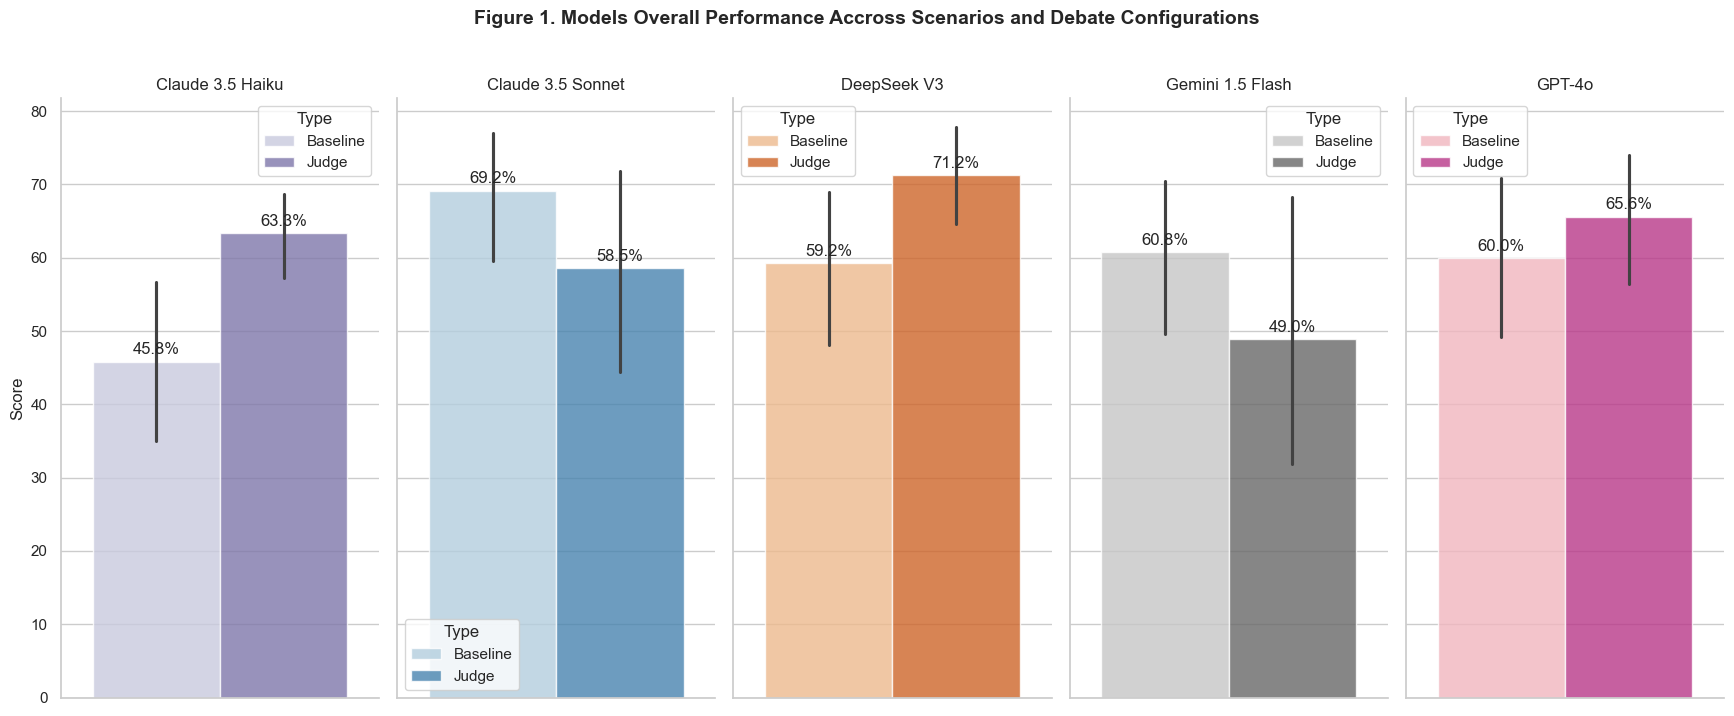

In [12]:
title = (
    "Figure 1. Models Overall Performance Accross Scenarios and Debate Configurations"
)

# Create faceted bar plot
g = sns.FacetGrid(melted_df, col="Model", height=7, aspect=0.5)

# Define different palettes for each facet
for i, ax in enumerate(g.axes.flat):
    sns.barplot(
        data=melted_df[melted_df["Model"] == g.col_names[i]],
        y="Score",
        hue="Type",
        alpha=0.8,
        palette=model_palette[g.col_names[i]],
        ax=ax,
    )


# Customize plot
# g.set_y_axis_labels("Scenario Label", "Accuracy (%)")
g.set_titles(col_template="{col_name}")
# g.add_legend(title="Mode", bbox_to_anchor=(1.0, 0.5), loc="center left")

# Add percentage labels
for ax in g.axes.flat:
    # for label in ax.get_xticklabels():
    #     label.set_rotation(60)
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt="%.1f%%",
            padding=3,
        )
plt.ylabel("Accuracy (%)")
plt.suptitle(
    title,
    y=1.02,
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

file_title = title.replace(" ", "_") + ".png"
g.savefig(figure_path / file_title)

In [13]:
# Calculate overall accuracy metrics
overall_metrics = []
for debate_name, dataframes in results.items():
    for model, df in dataframes.items():
        # Skip empty dataframes
        if len(df) == 0:
            continue

        # Calculate overall baseline and judge accuracy
        baseline_acc = accuracy_score(df["label"], df["baseline"])
        judge_acc = accuracy_score(df["label"], df["judge"])
        diff = judge_acc - baseline_acc

        # Add metrics to list
        overall_metrics.append(
            {
                "Debate": debate_name,
                "Model": model,
                "Baseline Accuracy": baseline_acc * 100,
                "Judge Accuracy": judge_acc * 100,
                "Difference": diff * 100,
                "Count": len(df),
            }
        )

# Create dataframe and sort by judge accuracy
overall_df = pd.DataFrame(overall_metrics)
overall_df = overall_df.sort_values("Judge Accuracy", ascending=False)
overall_df = overall_df.sort_values("Debate", ascending=False)

# Display results
print("Overall Model Performance:")
print(overall_df.to_markdown(index=False, floatfmt=".1f"))

Overall Model Performance:
| Debate        | Model             |   Baseline Accuracy |   Judge Accuracy |   Difference |   Count |
|:--------------|:------------------|--------------------:|-----------------:|-------------:|--------:|
| sonnet-sonnet | DeepSeek V3       |                64.2 |             79.0 |         14.8 |      81 |
| sonnet-sonnet | Claude 3.5 Haiku  |                45.8 |             67.5 |         21.7 |     240 |
| sonnet-sonnet | GPT-4o            |                60.0 |             65.8 |          5.8 |     240 |
| sonnet-sonnet | Claude 3.5 Sonnet |                69.2 |             61.3 |         -7.9 |     240 |
| sonnet-sonnet | Gemini 1.5 Flash  |                60.8 |             50.8 |        -10.0 |     240 |
| haiku-haiku   | GPT-4o            |                60.0 |             65.4 |          5.4 |     240 |
| haiku-haiku   | DeepSeek V3       |                57.5 |             63.7 |          6.2 |     240 |
| haiku-haiku   | Claude 3.5 Haiku  |

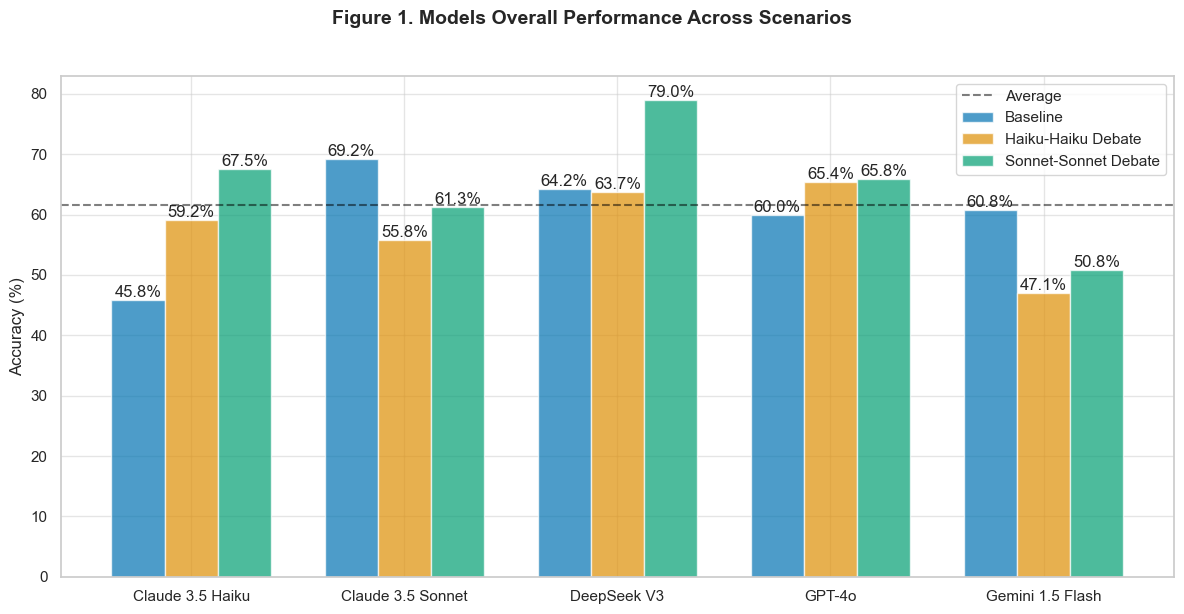

In [14]:
import numpy as np

title = "Figure 1. Models Overall Performance Across Scenarios"

# Create comparison plot
plt.figure(figsize=(12, 6))

# Get models in consistent order
models = sorted(metrics_df["Model"].unique())

# For each model, plot three bars
x = np.arange(len(models))
width = 0.25  # Width of bars

# Plot baseline bars
baseline = plt.bar(
    x - width,
    [
        overall_df[overall_df["Model"] == m]["Baseline Accuracy"].values[0]
        for m in models
    ],
    width,
    label="Baseline",
    alpha=0.7,
)

# Plot Haiku-Haiku bars
haiku = plt.bar(
    x,
    [
        overall_df[
            (overall_df["Model"] == m) & (overall_df["Debate"] == "haiku-haiku")
        ]["Judge Accuracy"].values[0]
        for m in models
    ],
    width,
    label="Haiku-Haiku Debate",
    alpha=0.7,
)

# Plot Sonnet-Sonnet bars
sonnet = plt.bar(
    x + width,
    [
        overall_df[
            (overall_df["Model"] == m) & (overall_df["Debate"] == "sonnet-sonnet")
        ]["Judge Accuracy"].values[0]
        for m in models
    ],
    width,
    label="Sonnet-Sonnet Debate",
    alpha=0.7,
)


# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(
            rect.get_x() + rect.get_width() / 2.0,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
        )


autolabel(baseline)
autolabel(haiku)
autolabel(sonnet)

# Add average line
average = overall_df["Judge Accuracy"].mean()
plt.axhline(average, color="black", linestyle="--", alpha=0.5, label="Average")

plt.ylabel("Accuracy (%)")
plt.suptitle(title, y=1.02, fontsize=14, fontweight='bold')
plt.xticks(x, models, ha="center")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig(figure_path / (title.replace(" ", "_") + ".png"), bbox_inches="tight")
plt.show()
plt.close()

## By Answer Label

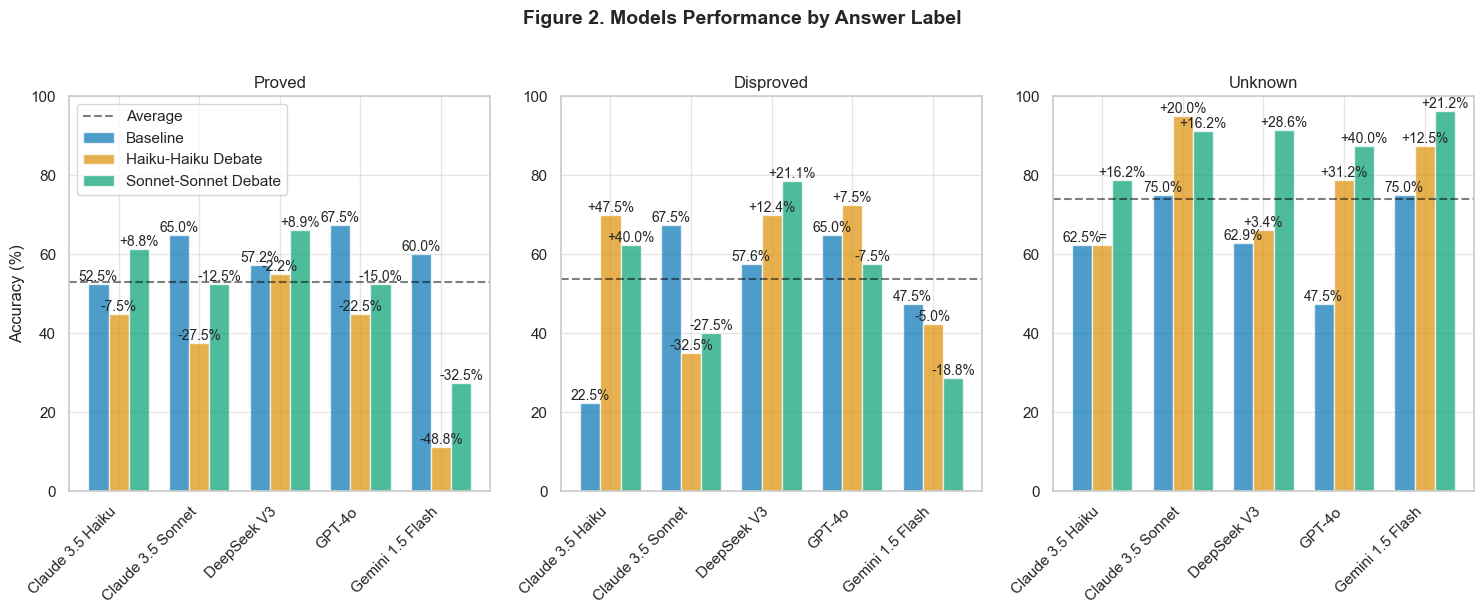

In [15]:
# Create figure with proper dimensions for faceting by answer label
fig = plt.figure(figsize=(15, 6))
title = "Figure 2. Models Performance by Answer Label"

# Create a subplot for each answer label
labels = ['Proved', 'Disproved', 'Unknown']
for i, label in enumerate(labels, 1):
    ax = plt.subplot(1, 3, i)

    # Filter data for current label
    label_data = melted_df[melted_df['Label'] == label]

    # Get models in consistent order
    models = sorted(label_data['Model'].unique())
    x = np.arange(len(models))
    width = 0.5

    # Plot bars
    baseline = ax.bar(
        x - width/2,
        [label_data[(label_data['Model'] == m) & (label_data['Type'] == 'Baseline')]['Score'].mean() for m in models],
        width/2,
        label='Baseline',
        alpha=0.7,
    )

    # Plot bars for haiku-haiku
    judge_haiku = ax.bar(
        x,
        [label_data[(label_data['Model'] == m) & (label_data['Type'] == 'Judge') &
                    (label_data['Debate'] == 'haiku-haiku')]['Score'].mean() for m in models],
        width/2,
        label='Haiku-Haiku Debate',
        alpha=0.7
    )

    # Plot bars for sonnet-sonnet
    judge_sonnet = ax.bar(
        x + width/2,
        [label_data[(label_data['Model'] == m) & (label_data['Type'] == 'Judge') &
                    (label_data['Debate'] == 'sonnet-sonnet')]['Score'].mean() for m in models],
        width/2,
        label='Sonnet-Sonnet Debate',
        alpha=0.7
    )



    # Add percentage labels
    for k, bar in enumerate(baseline):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10
        )

    for bars in [judge_haiku, judge_sonnet]:
        for k, bar in enumerate(bars):
            height = bar.get_height()
            baseline_val = baseline[k].get_height()
            diff = height - baseline_val
            sign = '+' if diff > 0 else ''
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height,
                sign + f'{diff:.1f}%' if diff != 0 else '=',
                ha='center',
                va='bottom',
                fontsize=10
            )

    # Customize subplot
    ax.set_ylabel('Accuracy (%)' if i == 1 else '')
    ax.set_ylim(0, 100)
    ax.set_title(f'{label}')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.grid(True, alpha=0.5)
    # Average line
    average = label_data['Score'].mean()
    ax.axhline(average, color='black', linestyle='--', alpha=0.5, label='Average')

    if i == 1:
        ax.legend(loc='upper left')


# Add overall title
plt.suptitle(title, y=1.02, fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig(figure_path / (title.replace(" ", "_") + ".png"), bbox_inches='tight')
plt.show()
# Save figure
plt.close()


## By Conflict Level

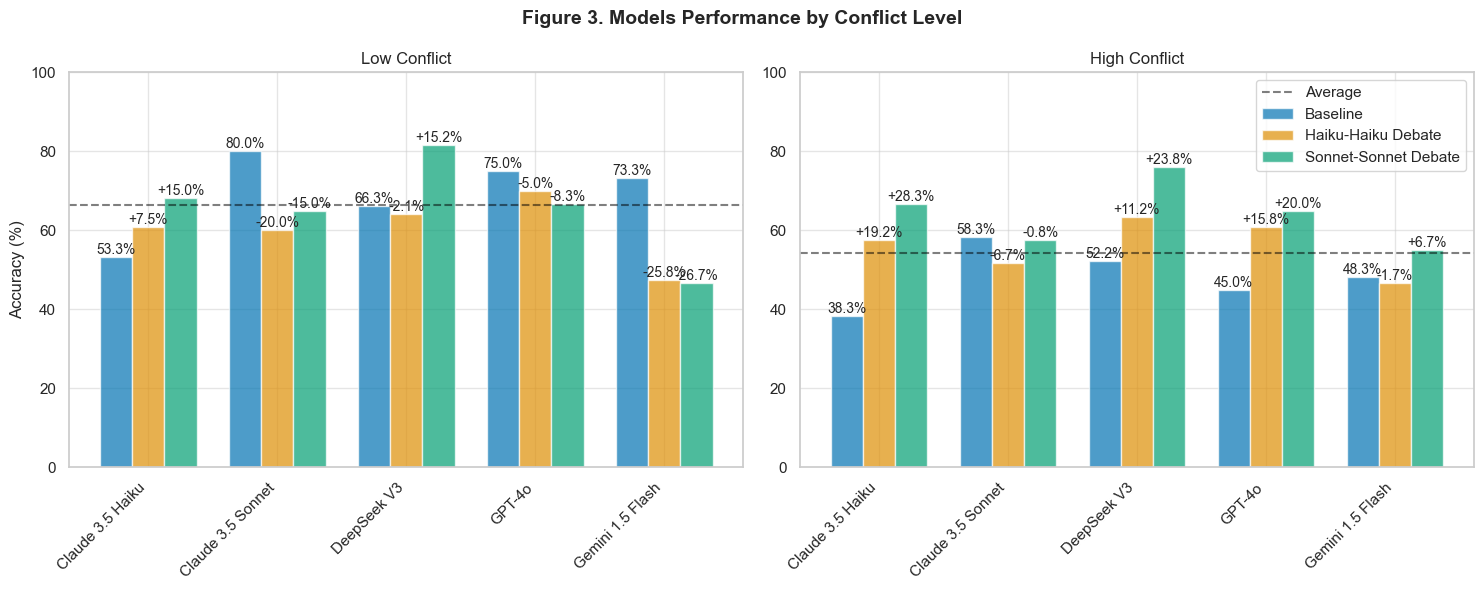

In [16]:
# Create figure with proper dimensions for faceting by answer label
fig = plt.figure(figsize=(15, 6))
title = "Figure 3. Models Performance by Conflict Level"

# Create a subplot for each answer label
labels = ['Low Conflict', 'High Conflict']
for i, label in enumerate(labels, 1):
    ax = plt.subplot(1, 2, i)

    # Filter data for current label
    label_data = melted_df[melted_df['Level'] == label]

    # Get models in consistent order
    models = sorted(label_data['Model'].unique())
    x = np.arange(len(models))
    width = 0.5

    # Plot bars
    baseline = ax.bar(
        x - width/2,
        [label_data[(label_data['Model'] == m) & (label_data['Type'] == 'Baseline')]['Score'].mean() for m in models],
        width/2,
        label='Baseline',
        alpha=0.7,
    )

    # Plot bars for haiku-haiku
    judge_haiku = ax.bar(
        x,
        [label_data[(label_data['Model'] == m) & (label_data['Type'] == 'Judge') &
                    (label_data['Debate'] == 'haiku-haiku')]['Score'].mean() for m in models],
        width/2,
        label='Haiku-Haiku Debate',
        alpha=0.7
    )

    # Plot bars for sonnet-sonnet
    judge_sonnet = ax.bar(
        x + width/2,
        [label_data[(label_data['Model'] == m) & (label_data['Type'] == 'Judge') &
                    (label_data['Debate'] == 'sonnet-sonnet')]['Score'].mean() for m in models],
        width/2,
        label='Sonnet-Sonnet Debate',
        alpha=0.7
    )


    # Add percentage labels
    for k, bar in enumerate(baseline):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10
        )

    for bars in [judge_haiku, judge_sonnet]:
        for k, bar in enumerate(bars):
            height = bar.get_height()
            baseline_val = baseline[k].get_height()
            diff = height - baseline_val
            sign = '+' if diff > 0 else ''
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height,
                sign + f'{diff:.1f}%' if diff != 0 else '=',
                ha='center',
                va='bottom',
                fontsize=10
            )

    # Average line
    average = label_data['Score'].mean()
    ax.axhline(average, color='black', linestyle='--', alpha=0.5, label='Average')


    # Customize subplot
    ax.set_ylabel('Accuracy (%)' if i == 1 else '')
    ax.set_ylim(0, 100)
    ax.set_title(f'{label}')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.grid(True, alpha=0.5)
    if i == 2:
        ax.legend(loc='upper right')

# Add overall title
plt.suptitle(title, fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.savefig(figure_path / (title.replace(" ", "_") + ".png"), bbox_inches='tight')
plt.show()
# Save figure
plt.close()


In [40]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

# Store test results
test_results = []

# Perform McNemar's test for each model and debate type
for debate_name, dataframes in results.items():
    for model, df in dataframes.items():
        # Create contingency table comparing baseline vs judge predictions
        baseline_correct = df['label'] == df['baseline']
        judge_correct = df['label'] == df['judge']

        # Contingency table counts
        b0_j0 = np.sum((~baseline_correct) & (~judge_correct))  # both wrong
        b0_j1 = np.sum((~baseline_correct) & judge_correct)     # baseline wrong, judge right
        b1_j0 = np.sum(baseline_correct & (~judge_correct))     # baseline right, judge wrong
        b1_j1 = np.sum(baseline_correct & judge_correct)        # both right

        # Create contingency table
        contingency = [[b0_j0, b0_j1],
                       [b1_j0, b1_j1]]

        # Perform McNemar's test
        try:
            result = mcnemar(contingency, exact=True)
            statistic = result.statistic
            pvalue = result.pvalue
        except ValueError:
            # Handle cases where test cannot be performed
            statistic, pvalue = np.nan, np.nan

        test_results.append({
            'Debate': debate_name,
            'Model': model,
            'Statistic': statistic,
            'P-value': pvalue,
            'Baseline Correct': sum(baseline_correct),
            'Judge Correct': sum(judge_correct),
            'Total Cases': len(df)
        })

# Create DataFrame with results
print("McNemar's Test Results:")
test_results_df = pd.DataFrame(test_results)
test_results_df['Significant'] = test_results_df['P-value'] < 0.05
print(test_results_df.to_markdown(index=False, floatfmt='.4f'))

McNemar's Test Results:
| Debate        | Model             |   Statistic |   P-value |   Baseline Correct |   Judge Correct |   Total Cases | Significant   |
|:--------------|:------------------|------------:|----------:|-------------------:|----------------:|--------------:|:--------------|
| haiku-haiku   | Claude 3.5 Haiku  |     34.0000 |    0.0018 |                110 |             142 |           240 | True          |
| haiku-haiku   | Claude 3.5 Sonnet |     32.0000 |    0.0014 |                166 |             134 |           240 | True          |
| haiku-haiku   | DeepSeek V3       |     47.0000 |    0.1797 |                138 |             153 |           240 | False         |
| haiku-haiku   | DeepSeek R1       |      0.0000 |    1.0000 |                  0 |               0 |             0 | False         |
| haiku-haiku   | Gemini 1.5 Flash  |     39.0000 |    0.0022 |                146 |             113 |           240 | True          |
| haiku-haiku   | GPT-4o       

## Debater Quotes

In [19]:
results["haiku-haiku"]["DeepSeek V3"].head()

,scenario_id,record_id,level,correct_debater_pos,label,baseline,judge,chosen_debater,a_quote_acc,a_quote_num,b_quote_acc,b_quote_num,chosen_debater_quote_acc_diff
0,017b322cf0dd120cab08cf4060708b61,5d02dff9-493f-4215-87ca-aa978ecf14bb,HighConflict,1,proved,disproved,disproved,2,0.666667,3,1.0,6,0.333333
2,017b322cf0dd120cab08cf4060708b61,f90a85fb-3a0f-4e89-8e92-01f401ccae07,HighConflict,2,proved,disproved,proved,2,1.000000,3,1.0,8,0.000000
4,01e8feaa80c08cd2188a9ab3e1b8be5e,56b43d93-9a18-4264-98d1-31b87b37196c,LowConflict,2,disproved,proved,disproved,2,1.000000,6,1.0,9,0.000000
5,01e8feaa80c08cd2188a9ab3e1b8be5e,f759c51f-e65c-4c57-a154-9681cef084a0,LowConflict,1,disproved,proved,disproved,1,0.750000,4,1.0,7,-0.250000
6,01eac4dc70fa41d7dbf22506ad98c6e6,1b8e5cac-6233-4090-9cbc-e4ad069d4e59,HighConflict,2,disproved,disproved,unknown,1,0.875000,8,1.0,9,-0.125000


In [20]:
"""
Use
a_quote_acc, a_quote_num, b_quote_acc, b_quote_num, and chosen debater (1=a, 2=b)
to calculate the effect of debater quote mechanism on the judge's decision
"""

# Calculate the effect of debater quote mechanism on the judge's decision


"\nUse\na_quote_acc, a_quote_num, b_quote_acc, b_quote_num, and chosen debater (1=a, 2=b)\nto calculate the effect of debater quote mechanism on the judge's decision\n"

# Failure Modes

In [41]:
# Get the record where Haiku is correct but Sonnet is incorrect

for debate_name, dfs in results.items():
    for model, df in dfs.items():
        df["Judge Correct"] = df["label"] == df["judge"]

C:\Users\Hp\AppData\Local\Temp\ipykernel_37360\1574902319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Judge Correct"] = df["label"] == df["judge"]


In [42]:

haiku_cor_sonnet_inc = {}
for debate_name, dfs in results.items():
    haiku_correct = dfs["Claude 3.5 Haiku"][
        dfs["Claude 3.5 Haiku"]["Judge Correct"] == 1
    ]["record_id"]
    sonnet_correct = dfs["Claude 3.5 Sonnet"][
        dfs["Claude 3.5 Sonnet"]["Judge Correct"] == 1
    ]["record_id"]

    haiku_cor_sonnet_inc[debate_name] = set(haiku_correct) - set(sonnet_correct)

print("Number of debate records where Haiku correct but Sonnet incorrect")
for debate_name, record_ids in haiku_cor_sonnet_inc.items():
    print(f"{debate_name}: {len(record_ids)}")

Number of debate records where Haiku correct but Sonnet incorrect
haiku-haiku: 39
sonnet-sonnet: 37


In [23]:
# Get the label proportions for the scenarios where Haiku is correct but Sonnet is incorrect

print(
    "Label & Level Proportions for Debate Records where Haiku is Correct but Sonnet is Incorrect:"
)
for debate_name, record_ids in haiku_cor_sonnet_inc.items():
    haiku_cor_sonnet_inc_df = results[debate_name]["Claude 3.5 Haiku"][
        results[debate_name]["Claude 3.5 Haiku"]["record_id"].isin(record_ids)
    ]
    print(f"===== {debate_name} =====")
    print(haiku_cor_sonnet_inc_df["label"].value_counts().to_string())
    print()
    print(haiku_cor_sonnet_inc_df["level"].value_counts().to_string())
    print()

Label & Level Proportions for Debate Records where Haiku is Correct but Sonnet is Incorrect:
===== haiku-haiku =====
label
disproved    28
proved       10
unknown       1

level
HighConflict    23
LowConflict     16

===== sonnet-sonnet =====
label
disproved    22
proved       14
unknown       1

level
LowConflict     19
HighConflict    18



In [24]:
import json


def get_scenario_id(record_id: str, df: pd.DataFrame) -> str:
    return df[df["record_id"] == record_id]["scenario_id"].values[0]

text = []
unverified_mentioned_count = 0
for debate_name, record_ids in haiku_cor_sonnet_inc.items():
        record2scenario = {
            record_id: get_scenario_id(record_id, results[debate_name]["Claude 3.5 Haiku"]) for record_id in record_ids
            }
        scenario2record = {}
        for record_id, scenario_id in record2scenario.items():
            if scenario_id not in scenario2record:
                scenario2record[scenario_id] = []
            scenario2record[scenario_id].append(record_id)


            base_path = Path("../results")
            for scenario_id in scenario2record.keys():
                # Load the scenario text
                with open(base_path / "scenarios" / f"{scenario_id}.json", "r") as file:
                    scenario_text = json.loads(file.read())

                text.append(f"# Scenario ID: {scenario_id}")
                text.append(json.dumps(scenario_text, indent=2))

                judge_text = []
                for record_id in scenario2record[scenario_id]:
                    judge_text.append(f"\n## Record ID: {record_id} ({debate_name} debate)")

                    with open(
                        base_path
                        / "debates"
                        / debate_name
                        / f"{scenario_id}_{record_id}.json",
                        "r",
                    ) as file:
                        debate = json.load(file)
                    judge_text.append(json.dumps(debate["debater_positions"], indent=2))

                    # Display the judge's answer
                    judge_text.append("\nJudge's Answer:\n")
                    for model in ["claude-3-5-sonnet-20241022", "claude-3-5-haiku-20241022"]:

                        with open(
                            base_path
                            / "judgements"
                            / debate_name
                            / model
                            / f"{scenario_id}_{record_id}.json",
                            "r",
                        ) as file:
                            answer = json.load(file)

                        judge_text.append(f"### {model}:")
                        judge_text.append(answer["judgement"])

                judge_text = "\n".join(judge_text)
                unverified_mentioned_count += int("unverified" in judge_text)
                text.append(judge_text)
                text.append("\n" + "=" * 80 + "\n")

text = "\n".join(text)
with open(report_path / "haiku_correct_sonnet_incorrect.md", "w", encoding="utf-8") as file:
    file.write(text)

In [25]:
unverified_mentioned_count

417